# <center>DeepIRTools Tutorial:<br><br>Analyzing a Big-Five Personality Factors Data Set</center>

DeepIRTools is a small Python package that uses scalable deep learning methods (e.g., [Urban and Bauer, 2021](#refs)) to fit several kinds of latent factors models, with a particular focus on item response theory (IRT) models. In this Notebook, we demonstrate some of DeepIRTools' capabilities via a large-scale real data example.

We begin by downloading and pre-processing the data set, which consists of over 1 million people's responses to 50 Big-Five personality factors items. There are 10 items designed to measure each personality factor, and each item has 5 response categories ranging from 1 = Disagree to 5 = Agree.

After some basic pre-processing, we cut the data set down to around 630K people.

In [1]:
import os
import urllib.request
import shutil
import pandas as pd
import seaborn as sns
import torch
import numpy as np

import deepirtools

deepirtools.manual_seed(123) # Set seed for reproducibility.

# Download data.
filepath = "./data/IPIP-FFM-data-8Nov2018/data-final.csv"
if not os.path.exists(filepath):
    os.makedirs(os.path.dirname("./data/"), exist_ok=True)
    urllib.request.urlretrieve("https://openpsychometrics.org/_rawdata/IPIP-FFM-data-8Nov2018.zip",
                               "./data/ipip-ffm.zip")
    shutil.unpack_archive("./data/ipip-ffm.zip", "./data/")

# Pre-processing.
df = pd.read_csv(filepath, sep = "\t", header = 0)
df = df[df["IPC"] == 1] # Drop multiple submissions from same IP address.
df.iloc[:, :100] = df.iloc[:, :100].dropna() # Drop people with all NaN responses.
df = df[df.iloc[:, 0:50].sum(1) > 0] # Drop people with all missing responses.
rc_items = ["EXT2", "EXT4", "EXT6", "EXT8", "EXT10", "AGR1", "AGR3", "AGR5", "AGR7",
            "CSN2", "CSN4", "CSN6", "CSN8", "EST2", "EST4", "OPN2", "OPN4", "OPN6"]
df[rc_items] = ((1 - df[rc_items] / 5) * 5 + 1).mask(lambda col: col == 6, 0) # Reverse-code reverse-coded items.
Y = torch.from_numpy(df.iloc[:, :50].to_numpy()) - 1 # Collect item responses.
T = torch.from_numpy(df.iloc[:, 50:100].to_numpy()) / 1000 # Collect response times in seconds.

missing_mask = 1 * (Y != -1)
Y[Y == -1] = 0
T[T == 0] = 1e-7 # Set zero response times (which indicate missingness) to a small value.

keeps = ((T < 0).sum(dim = 1) == 0) & ((T > 100).sum(dim = 1) == 0) # Drop negative or overly long response times.
Y, T, missing_mask = Y[keeps], T[keeps], missing_mask[keeps]

print(Y.shape) # Matrix of shape [no. people X no. items].

n_items = Y.shape[1]

torch.Size([629984, 50])


## Exploratory Analyses

We first demonstrate exploratory factor analysis. Since the items are ordinal (ordered categorical), an appropriate measurement model is [Samejima's (1969)](#refs) graded response model (GRM):
\begin{equation}
    \text{Pr}(y_j \geq k \mid \boldsymbol{x}) = \sigma(\alpha_{j, k} + \boldsymbol{\beta}_j^\top\boldsymbol{x}), \qquad k = 0, 1, \ldots, K_j - 1,
\end{equation}
where $y_j$ is the response to item $j$, $\boldsymbol{x}$ is a $D \times 1$ vector of latent variables, $\alpha_{j, k}$ is the $k^\text{th}$ category intercept for item $j$, and $\boldsymbol{\beta}_j$ is a $D \times 1$ loadings vector for item $j$, and $K_j$ is the number of responses categories for item $j$, $j = 1, \ldots, J$. Here, $\sigma(z) = 1 / (1 + \exp[-z])$ is the inverse logistic link function. The conditional probability of a particular item response is given by:
\begin{equation}
    \text{Pr}(y_j = k \mid \boldsymbol{x}) = \text{Pr}(y_j \geq k \mid \boldsymbol{x}) - \text{Pr}(y_j \geq k + 1 \mid \boldsymbol{x}).
\end{equation}

A typical goal in the exploratory context is to determine the number of latent factors $D$ underlying the data. We can do this using an approximate log-likelihood (LL) scree plot approach wherein we fit multiple models with different latent dimensions and estimate the approximate LL on a held-out data set for each dimension [(Urban & Bauer, 2021)](#refs). We can then plot these approximate LLs and pick the latent dimension corresponding to an "elbow" in the plot.

We demonstrate the screeplot approach below. Of particlar interest are the `iw_samples_fit` and `iw_samples_ll` arguments. DeepIRTools uses an approximate maximum likelihood (ML) estimator called an importance-weighted amortized variational estimator (I-WAVE) to fit and evaluate models. Increasing the number of importance-weighted (IW) samples during fitting brings our estimates closer to the ML estimates, while doing so during evaluation brings our approximate LL closer to the true LL. However, increasing these arguments may also incur additional computing time. In practice, using a small number of IW samples during fitting often performs well (see [Urban and Bauer, 2021](#refs)).


Latent size =  3

Fitting started
Epoch =       0 Iter. =  18401 Cur. loss =   66.59   Intervals no change = 100


Fitting ended in  55.26  seconds

Computing approx. LL
Approx. LL computed in 11.59 seconds

Latent size =  4

Fitting started
Epoch =       0 Iter. =  17201 Cur. loss =   62.53   Intervals no change = 100


Fitting ended in  52.16  seconds

Computing approx. LL
Approx. LL computed in 8.15 seconds

Latent size =  5

Fitting started
Epoch =       0 Iter. =  16201 Cur. loss =   63.21   Intervals no change = 100


Fitting ended in  45.52  seconds

Computing approx. LL
Approx. LL computed in 7.3 seconds

Latent size =  6

Fitting started
Epoch =       1 Iter. =  21501 Cur. loss =   63.12   Intervals no change = 100


Fitting ended in  59.72  seconds

Computing approx. LL
Approx. LL computed in 7.37 seconds

Latent size =  7

Fitting started
Epoch =       1 Iter. =  29401 Cur. loss =   61.76   Intervals no change = 100


Fitting ended in  84.6  seconds

Computing approx. LL
Ap

/Users/gateslab/opt/anaconda3/lib/python3.9/site-packages/deepirtools/figures.py:94: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


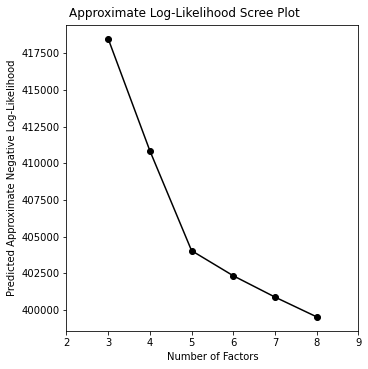

In [2]:
latent_sizes = [3, 4, 5, 6, 7, 8] # List of latent dimensions to plot.
lrs = [(0.1/(latent_size+1))*5**-1 for latent_size in latent_sizes] # Step sizes for optimization procedure,
                                                                    # scaled according to latent dimension.
                                                                    # We find this often works well empirically.
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if available, else use CPU.

# This will take a few minutes to run since we're fitting and evaluating multiple models.
ll_list = deepirtools.screeplot(
            latent_sizes = latent_sizes,
            data = Y,
            model_type = "grm", # "grm" = graded response model.
            test_size = 0.01, # Hold out 1 percent of the data for computing the LL.
            inference_net_sizes_list = [[100]] * 6, # Neural net sizes.
            learning_rates = lrs,
            missing_mask = missing_mask, # Indicates locations of missing item responses.
            device = device,                  
            iw_samples_fit = 5, # Increasing improves approximation to the ML estimator during fitting.
            iw_samples_ll = 500, # Increasing improves approximation to true LL during evaluation.
            n_cats = [5] * n_items, # Number of categories per item.
           )

Another goal in the exploratory context is to uncover the factor loadings structure. This is typically accomplished by fitting one model with a given latent dimension where the factors are standard normally distributed:
\begin{equation}
    \boldsymbol{x} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{I}_D).
\end{equation}
The factor loadings are rotated *post-hoc* to arrive at an interpretable solution. If the rotation is oblique, we also obtain estimates of the factor correlations.

Since we found an "elbow" in our approximate LL scree plot at 5 latent factors, we fit a 5-factor GRM with standard normal factors. We then use Geomin oblique rotation from the FactorAnalyzer package to produce rotated loadings, which have a rather clear simple structure, as well as factor correlations.


Fitting started
Epoch =       0 Iter. =  18701 Cur. loss =   65.48   Intervals no change = 100


Fitting ended in  58.23  seconds


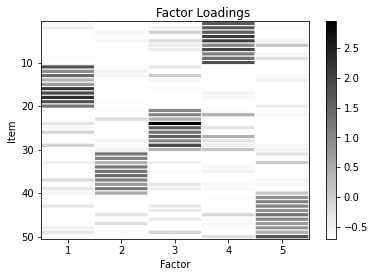


Factor correlations

 [[ 1.    0.17 -0.01  0.16 -0.06]
 [ 0.17  1.    0.11  0.08  0.04]
 [-0.01  0.11  1.    0.12 -0.07]
 [ 0.16  0.08  0.12  1.   -0.09]
 [-0.06  0.04 -0.07 -0.09  1.  ]]


In [3]:
from deepirtools import IWAVE
from factor_analyzer import Rotator

latent_size = 5
lr = (0.1/(latent_size+1))*5**-1

model = IWAVE(learning_rate = lr,
              device = device,
              model_type = "grm",
              log_interval = 100,
              input_size = n_items,
              inference_net_sizes = [100],
              latent_size = latent_size,
              n_cats = [5] * n_items,
             )
model.fit(Y, missing_mask=missing_mask, iw_samples=5)

rotator = Rotator(method = "geomin_obl")
rot_loadings = rotator.fit_transform(model.loadings)
deepirtools.loadings_heatmap(rot_loadings)
print("\nFactor correlations\n\n", np.around(rotator.phi_, 2))

## Confirmatory Analyses

### Measurement Models for Categorical Data

In the confirmatory IFA setting, researchers have *a priori* theories that correspond to particular loadings and factor correlation structures. These structures are implemented by placing restrictions on the loadings and factor correlations, and the resulting fitted models are tested for model-data fit.

There are several ways to implement loadings constraints. One is to use a $J \times D$ binary matrix $Q$ whose elements are zero if the corresponding loading is set to zero and one otherwise:
\begin{equation}
    \beta_{j, d} = q_{j, d} \beta_{j, d}',
\end{equation}
where $\beta_{j, d}$ is the loading for item $j$ on factor $d$, $q_{j, d} \in \{0, 1\}$ is an element of $Q$, and $\beta_{j, d}'$ is an unconstrained loading.

We demonstrate this approach for the GRM by imposing simple stucture on the loadings matrix using $Q$ below. We also estimate the correlations between the latent factors using a spherical parameterization [(Pinheiro & Bates, 1996)](#refs).

In [4]:
Q = torch.block_diag(*[torch.ones([10, 1])] * 5) # Binary matrix imposing simple structure on the loadings.

model = IWAVE(learning_rate = lr,
              device = device,
              model_type = "grm",
              log_interval = 100,
              Q = Q,
              input_size = n_items,
              inference_net_sizes = [100],
              latent_size = latent_size,
              n_cats = [5] * n_items,
              correlated_factors = [0, 1, 2, 3, 4], # Estimates the correlations between any
                                                    # factors included in this list; o/s are
                                                    # constrained to zero.
             )
model.fit(Y, missing_mask=missing_mask, iw_samples=5)

print("\nLoadings\n\n", np.around(model.loadings.numpy(), 2))
print("\nFactor correlations\n\n", np.around(model.cov.numpy(), 2))
print("\nIntercepts\n\n", np.around(model.intercepts.numpy(), 2))


Fitting started
Epoch =       1 Iter. =  25401 Cur. loss =   62.78   Intervals no change = 100


Fitting ended in  115.17  seconds

Loadings

 [[1.86 0.   0.   0.   0.  ]
 [2.   0.   0.   0.   0.  ]
 [1.95 0.   0.   0.   0.  ]
 [2.26 0.   0.   0.   0.  ]
 [2.36 0.   0.   0.   0.  ]
 [1.53 0.   0.   0.   0.  ]
 [2.21 0.   0.   0.   0.  ]
 [1.39 0.   0.   0.   0.  ]
 [1.55 0.   0.   0.   0.  ]
 [2.12 0.   0.   0.   0.  ]
 [0.   1.94 0.   0.   0.  ]
 [0.   1.38 0.   0.   0.  ]
 [0.   1.55 0.   0.   0.  ]
 [0.   0.96 0.   0.   0.  ]
 [0.   1.2  0.   0.   0.  ]
 [0.   2.24 0.   0.   0.  ]
 [0.   2.22 0.   0.   0.  ]
 [0.   2.5  0.   0.   0.  ]
 [0.   1.85 0.   0.   0.  ]
 [0.   1.74 0.   0.   0.  ]
 [0.   0.   1.31 0.   0.  ]
 [0.   0.   1.55 0.   0.  ]
 [0.   0.   0.71 0.   0.  ]
 [0.   0.   2.63 0.   0.  ]
 [0.   0.   1.95 0.   0.  ]
 [0.   0.   1.38 0.   0.  ]
 [0.   0.   1.88 0.   0.  ]
 [0.   0.   1.49 0.   0.  ]
 [0.   0.   2.14 0.   0.  ]
 [0.   0.   1.03 0.   0.  ]
 [0.   0.   0.  

We can implement a wider range of confirmatory IFA models using linear constraints on the loadings:
\begin{equation}
    \boldsymbol{\beta} = \boldsymbol{b} + \boldsymbol{A} \boldsymbol{\beta}',
\end{equation}
where $\boldsymbol{\beta} = (\beta_{1, 1}, \ldots, \beta_{J, 1}, \ldots, \beta_{1, D}, \ldots, \beta_{J, D})^\top$ is a $DJ \times 1$ vector of constrained loadings values, $\boldsymbol{b}$ is a $DJ \times 1$ vector of constants, $\boldsymbol{A}$ is a $DJ \times DJ$ matrix of constants, and $\boldsymbol{\beta}' = (\beta_{1, 1}', \ldots, \beta_{J, 1}', \ldots, \beta_{1, D}', \ldots, \beta_{J, D}')^\top$ is a $DJ \times 1$ vector of unconstrained loadings. This approach is more complicated than using $Q$, but also allows for more complicated constraints like setting a loading to a constant or setting multiple loadings equal.

Below, we fit a model with simple structure where the first loading on each factor is constrained to 1 and the factor variances are freely estimated.

In [5]:
constraint_ls = ([torch.zeros(1), torch.eye(9), torch.zeros([n_items, n_items]),
                  torch.zeros(1), torch.eye(9), torch.zeros([n_items, n_items]),
                  torch.zeros(1), torch.eye(9), torch.zeros([n_items, n_items]),
                  torch.zeros(1), torch.eye(9), torch.zeros([n_items, n_items]),
                  torch.zeros(1), torch.eye(9)])
A = torch.block_diag(*constraint_ls)
b = torch.cat(([torch.ones(1), torch.zeros([9 + n_items]),
                torch.ones(1), torch.zeros([9 + n_items]),
                torch.ones(1), torch.zeros([9 + n_items]),
                torch.ones(1), torch.zeros([9 + n_items]),
                torch.ones(1), torch.zeros([9])]), dim=0)

model = IWAVE(learning_rate = lr,
              device = device,
              model_type = "grm",
              log_interval = 100,
              A = A,
              b = b,
              input_size = n_items,
              inference_net_sizes = [100],
              latent_size = latent_size,
              n_cats = [5] * n_items,
              fixed_variances = False,
              correlated_factors = [0, 1, 2, 3, 4],
             )
model.fit(Y, missing_mask=missing_mask, iw_samples=5)

print("\nLoadings\n\n", np.around(model.loadings.numpy(), 2))
print("\nFactor covariances\n\n", np.around(model.cov.numpy(), 2))
print("\nIntercepts\n\n", np.around(model.intercepts.numpy(), 2))


Fitting started
Epoch =       1 Iter. =  22701 Cur. loss =   65.82   Intervals no change = 100


Fitting ended in  105.67  seconds

Loadings

 [[1.   0.   0.   0.   0.  ]
 [1.03 0.   0.   0.   0.  ]
 [0.99 0.   0.   0.   0.  ]
 [1.19 0.   0.   0.   0.  ]
 [1.25 0.   0.   0.   0.  ]
 [0.77 0.   0.   0.   0.  ]
 [1.15 0.   0.   0.   0.  ]
 [0.75 0.   0.   0.   0.  ]
 [0.85 0.   0.   0.   0.  ]
 [1.09 0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.  ]
 [0.   0.64 0.   0.   0.  ]
 [0.   0.77 0.   0.   0.  ]
 [0.   0.5  0.   0.   0.  ]
 [0.   0.62 0.   0.   0.  ]
 [0.   1.14 0.   0.   0.  ]
 [0.   1.14 0.   0.   0.  ]
 [0.   1.3  0.   0.   0.  ]
 [0.   0.97 0.   0.   0.  ]
 [0.   0.92 0.   0.   0.  ]
 [0.   0.   1.   0.   0.  ]
 [0.   0.   1.18 0.   0.  ]
 [0.   0.   0.57 0.   0.  ]
 [0.   0.   2.05 0.   0.  ]
 [0.   0.   1.44 0.   0.  ]
 [0.   0.   1.08 0.   0.  ]
 [0.   0.   1.43 0.   0.  ]
 [0.   0.   1.12 0.   0.  ]
 [0.   0.   1.63 0.   0.  ]
 [0.   0.   0.77 0.   0.  ]
 [0.   0.   0.  

Another widely used measurement model for categorical responses is the multidimensional generalized partial credit model (GPCM; [Yao & Schwarz, 2006](#refs)):
\begin{equation}
    \text{Pr}(y_j = k - 1 \mid \boldsymbol{x}) = \frac{\exp\big[(k - 1)\boldsymbol{\beta}_j^\top\boldsymbol{x} - \sum_{\ell = 1}^k \alpha_{j, \ell} \big]}{\sum_{m = 1}^{K_j} \exp \big[ (m - 1)\boldsymbol{\beta}_j^\top\boldsymbol{x} - \sum_{\ell = 1}^m \alpha_{j, \ell} \big]}, \qquad k = 1, \ldots, K_j,
\end{equation}
where all terms are defined as before.

We fit this model below using the $Q$ matrix approach.

In [6]:
Q = torch.block_diag(*[torch.ones([10, 1])] * 5)

model = IWAVE(learning_rate = lr,
              device = device,
              model_type = "gpcm",
              log_interval = 100,
              Q = Q,
              input_size = n_items,
              inference_net_sizes = [100],
              latent_size = latent_size,
              n_cats = [5] * n_items,
              correlated_factors = [0, 1, 2, 3, 4],
             )
model.fit(Y, missing_mask=missing_mask, iw_samples=5)

print("\nLoadings\n\n", np.around(model.loadings.numpy(), 2))
print("\nFactor correlations\n\n", np.around(model.cov.numpy(), 2))
print("\nIntercepts\n\n", np.around(model.intercepts.numpy(), 2))


Fitting started
Epoch =       1 Iter. =  20001 Cur. loss =   66.12   Intervals no change = 100


Fitting ended in  97.09  seconds

Loadings

 [[1.11 0.   0.   0.   0.  ]
 [1.1  0.   0.   0.   0.  ]
 [1.14 0.   0.   0.   0.  ]
 [1.4  0.   0.   0.   0.  ]
 [1.46 0.   0.   0.   0.  ]
 [0.78 0.   0.   0.   0.  ]
 [1.29 0.   0.   0.   0.  ]
 [0.68 0.   0.   0.   0.  ]
 [0.8  0.   0.   0.   0.  ]
 [1.21 0.   0.   0.   0.  ]
 [0.   1.07 0.   0.   0.  ]
 [0.   0.69 0.   0.   0.  ]
 [0.   0.86 0.   0.   0.  ]
 [0.   0.44 0.   0.   0.  ]
 [0.   0.58 0.   0.   0.  ]
 [0.   1.25 0.   0.   0.  ]
 [0.   1.34 0.   0.   0.  ]
 [0.   1.59 0.   0.   0.  ]
 [0.   1.02 0.   0.   0.  ]
 [0.   0.9  0.   0.   0.  ]
 [0.   0.   0.53 0.   0.  ]
 [0.   0.   0.94 0.   0.  ]
 [0.   0.   0.31 0.   0.  ]
 [0.   0.   1.8  0.   0.  ]
 [0.   0.   1.18 0.   0.  ]
 [0.   0.   0.67 0.   0.  ]
 [0.   0.   1.25 0.   0.  ]
 [0.   0.   0.92 0.   0.  ]
 [0.   0.   1.28 0.   0.  ]
 [0.   0.   0.57 0.   0.  ]
 [0.   0.   0.   

As an estimation byproduct, we obtain an artificial neural network (ANN; a kind of nonlinear regression model) that can be used to estimate approximate expected *a posteriori* factor scores or approximate log-likelihoods for data points (even if the data was not used for fitting). To estimate either approximate scores or LLs, two arguments must be specified:
1. `mc_samples`, the number of Monte Carlo (MC) samples used.
2. `iw_samples`, the number of importance-weighted (IW) samples used.

Increasing `mc_samples` reduces sampling variability so that estimates for approximate scores or LLs become more stable across random seeds. Increasing `iw_samples` brings the approximate EAPs and LLs closer to the true EAPs and LLs. However, computation time scales with the product of `mc_samples` and `iw_samples` and may become burdensome when both are too large. The researcher should set these arguments by weighing their computational resources against the needs of the project on hand.

We demonstrate approximate factor score and LL estimation for a subset of the Big-Five data below. The negative correlation between emotional stability and most other factors is visible in the scores plot.


Computing approx. LL
Approx. LL computed in 1.36 seconds
Approximate log-likelihood =  -65856.03


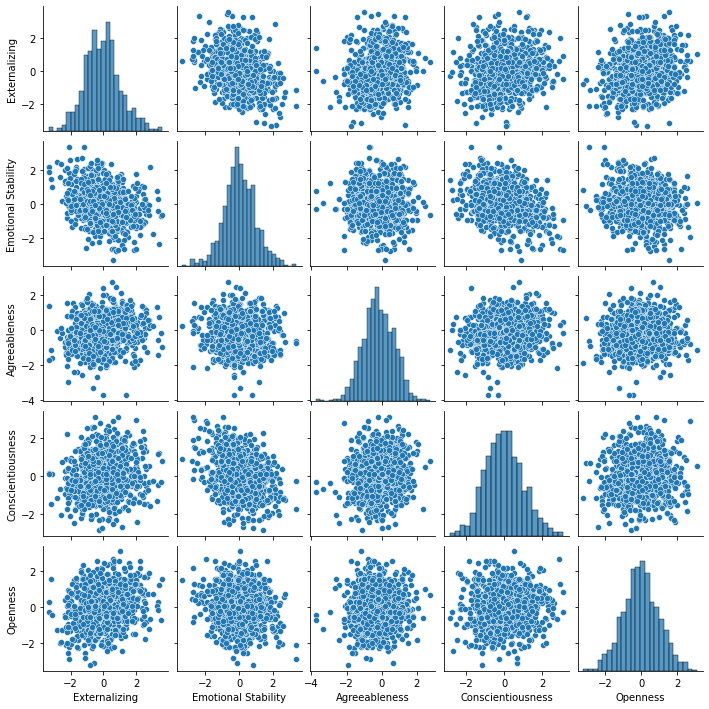

In [7]:
scores = model.scores(Y[:1000], missing_mask[:1000], mc_samples = 1, iw_samples = 500)

cols = ["Externalizing", "Emotional Stability", "Agreeableness", "Conscientiousness", "Openness"]
sns.pairplot(pd.DataFrame(scores.numpy(), columns = cols), height = 2)

ll = model.log_likelihood(Y[:1000], missing_mask[:1000], mc_samples = 1, iw_samples = 500)
print("Approximate log-likelihood = ", np.around(ll, 2))

**WARNING: This is an experimental feature that has not yet been thoroughly evaluated. Use at your own risk.**

It is common to assume that the latent factors are normally distributed (i.e., the latent prior is multivariate normal). In general, however, this assumption may be overly restrictive and may lead to poor model-data fit. As an alternative, we can model the latent prior using a flexible density called a neural spline flow [(NSF; Durkan, Bekasov, Murray, & Papamakarios, 2019)](#refs), which is theoretically capable of approximating any continuous multivariate probability distribution.

We demonstrate fitting the GPCM with an NSF prior below. By setting `fixed_variances = True`, the NSF density is constrained to have zero mean and unit variance to identify the location and scale of the latent factors. Notice that the factor scores mostly appear nearly normally distributed and the log-likelihood is actually slightly lower than when using a normal density, suggesting that the NSF may provide little benefit for this Big-5 data. 

In [ ]:
Q = torch.block_diag(*[torch.ones([10, 1])] * 5)

model = IWAVE(learning_rate = lr,
              device = device,
              model_type = "gpcm",
              log_interval = 100,
              Q = Q,
              input_size = n_items,
              inference_net_sizes = [100],
              latent_size = latent_size,
              n_cats = [5] * n_items,
              fixed_variances = True,
              use_spline_prior = True,
             )
model.fit(Y, missing_mask=missing_mask, iw_samples=5)

scores = model.scores(Y[:1000], missing_mask[:1000], mc_samples = 1, iw_samples = 500)

cols = ["Externalizing", "Emotional Stability", "Agreeableness", "Conscientiousness", "Openness"]
sns.pairplot(pd.DataFrame(scores.numpy(), columns = cols), height = 2)

ll = model.log_likelihood(Y[:1000], missing_mask[:1000], mc_samples = 1, iw_samples = 500)
print("Approximate log-likelihood = ", np.around(ll, 2))


Fitting started
Epoch =       0 Iter. =    601 Cur. loss =   68.02   Intervals no change =   0

### Measurement Models for Continuous Data

We can also fit classical linear factor models of the form:
\begin{equation}
    y_j \mid \boldsymbol{x} \sim \mathcal{N}(\boldsymbol{\beta}_j^\top\boldsymbol{x} + \alpha_j, \sigma_j^2),
\end{equation}
where $\sigma_j^2$ is the residual variance for item $j$, $j = 1, \ldots, J$.

We apply a confirmatory linear factor model to the (standardized) Big-Five data below. This analysis comes with the usual caveat that treating ordinal items as continuous may bias parameter estimates.

In [ ]:
Q = torch.block_diag(*[torch.ones([10, 1])] * 5)

model = IWAVE(learning_rate = lr,
              device = device,
              model_type = "normal",
              log_interval = 100,
              Q = Q,
              input_size = n_items,
              inference_net_sizes = [100],
              latent_size = latent_size,
              n_items = n_items,
              correlated_factors = [0, 1, 2, 3, 4],
             )
model.fit((Y - Y.mean(dim = 0)) / Y.std(dim = 0), missing_mask=missing_mask, iw_samples=5) # The data is standardized.

print("\nLoadings\n\n", np.around(model.loadings.numpy(), 2))
print("\nFactor correlations\n\n", np.around(model.cov.numpy(), 2))
print("\nIntercepts\n\n", np.around(model.intercepts.numpy(), 2))
print("\nResidual standard deviations\n\n", np.around(model.residual_std.numpy(), 2))

It is sometimes of interest to model strictly positive observed variables using a lognormal measurement model:
\begin{equation}
    \ln y_j \mid \boldsymbol{x} \sim \mathcal{N}(\boldsymbol{\beta}_j^\top\boldsymbol{x} + \alpha_j, \sigma_j^2),
\end{equation}
where $y_j > 0$, $j = 1, \ldots, J$.
For intstance, item response times are often modeled as
\begin{equation}
    \ln t_j \mid \tau \sim \mathcal{N}(\alpha_j - \tau, \sigma_j^2),
\end{equation}
where $t_j$ is the time taken to respond to item $j$, $\tau$ is a scalar latent "speed" variable, and all loadings are constrained to $-1$ ([van der Linden, 2006](#refs)). For this model, $\alpha_j$ is interpreted as the time intensity (i.e., consumingness) of item $j$ and $\sigma_j^{-1}$ is interpreted as how well item $j$ discriminates between people with different levels of speed.

We model the lognormal model to Big-Five response times below. We note that fitting may become numerically unstable when some response times are extremely large. To improve stability (and because extreme response times may be outliers), we have dropped individuals who took more than 100 seconds to respond to any question. We also decrease the learning rate and increase the batch size, which often helps stabilize fitting.

In [ ]:
A = torch.zeros([n_items, n_items])
b = -torch.ones(n_items)

model = IWAVE(learning_rate = 1e-3, # A small learning rate may work best here.
              device = device,
              model_type = "lognormal",
              log_interval = 100,
              A = A,
              b = b,
              input_size = n_items,
              inference_net_sizes = [100],
              latent_size = 1,
              n_items = n_items,
             )
model.fit(T, batch_size=128, missing_mask=missing_mask, iw_samples=5) # Increased batch size.

print("\nIntensities\n\n", np.around(model.intercepts.numpy(), 2))
print("\nDiscriminations\n\n", np.around(model.residual_std.pow(-1).numpy(), 2))

## References <a id='refs'></a>

- Durkan, C., Bekasov, A., Murray, I., & Papamakarios, G. (2019). Neural spline flows. *Advances in Neural Information Processing Systems*, *32*.

- Pinheiro, J. C., & Bates, D. M. (1996). Unconstrained parametrizations for variance-covariance matrices. *Statistics and Computing*, *6*(3), 289-296.

- Samejima, F. (1969). Estimation of latent ability using a response pattern of graded scores. *Psychometric Monographs*, *17*.

- Urban, C. J., & Bauer, D. J. (2021). A deep learning algorithm for high-dimensional exploratory item factor analysis. *Psychometrika*, *86*(1), 1-29.

- van der Linden, W. J. (2006). A lognormal model for response times on test items. *Journal of Educational and Behavioral Statistics*, *31*(2), 181-204.

- Yao, L., & Schwarz, R. D. (2006). A multidimensional partial credit model with associated item and test statistics: An application to mixed-format tests. *Applied Psychological Measurement*, *30*(6), 469-492.